In [1]:
import sys
import logging

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from torch.utils.data import DataLoader

In [5]:
import torchvision
from torchvision import datasets
from torchvision.utils import make_grid

In [6]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
)

# Data Load

In [7]:
train_dataset = datasets.MNIST(
    root='data',
    train=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
#         torchvision.transforms.Lambda(lambda x: torch.round(x)),
    ]),
    download=True,
)

In [8]:
test_dataset = datasets.MNIST(
    root='data',
    train=False,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
#         torchvision.transforms.Lambda(lambda x: torch.round(x)),
    ]),
    download=False,
)

In [9]:
len(train_dataset), len(test_dataset)

(60000, 10000)

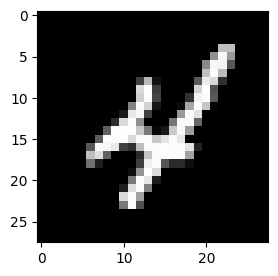

In [10]:
plt.figure(figsize=(3,3))
plt.imshow(train_dataset[9][0].detach().cpu().numpy()[0], cmap='gray')

In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

In [12]:
for batch in train_loader:
    data, labels = batch
    print(data.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


# Model

In [13]:
class Generator(nn.Module):
    def __init__(
        self,
        input_dim: int,
        n_channels: int
    ):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.n_channels = n_channels
        
        self.linear = nn.Linear(self.input_dim, 4 * 4 * 4 * self.n_channels)
        self.conv_block_1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=4 * self.n_channels,
                out_channels=2 * self.n_channels,
                kernel_size=3,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=2 * self.n_channels),
            nn.ReLU()
        )
        self.conv_block_2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=2 * self.n_channels,
                out_channels=1 * self.n_channels,
                kernel_size=2,
                stride=2,
            ),
            nn.BatchNorm2d(num_features=1 * self.n_channels),
            nn.ReLU(),
        )
        self.conv_block_3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=self.n_channels,
                out_channels=1,
                kernel_size=2,
                stride=2,
            ),
            nn.BatchNorm2d(num_features=1),
        )
        
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.relu(
            self.linear(x).view(-1, 4 * self.n_channels, 4, 4)
        )
        out = self.conv_block_1(out)
        out = self.conv_block_2(out)
        out = self.conv_block_3(out)
        return (torch.tanh(out) + 1) / 2
    
    def sample(self, batch_size: int) -> torch.Tensor:
        noise = torch.randn(batch_size, self.input_dim)
        return self.forward(noise)

In [14]:
generator = Generator(
    input_dim=128,
    n_channels=128
)

In [15]:
generator.sample(32).shape

torch.Size([32, 1, 28, 28])

In [16]:
class Critic(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
    ):
        super(Critic, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=self.in_channels,
                out_channels=self.out_channels,
                kernel_size=2,
                stride=2,
            ),
            nn.BatchNorm2d(num_features=self.out_channels),
            nn.LeakyReLU(0.2),
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=self.out_channels,
                out_channels=2 * self.out_channels,
                kernel_size=2,
                stride=2,
            ),
            nn.BatchNorm2d(num_features=2 * self.out_channels),
            nn.LeakyReLU(0.2),
        )
        
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=2 * self.out_channels,
                out_channels=4 * self.out_channels,
                kernel_size=2,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(num_features=4 * self.out_channels),
            nn.LeakyReLU(0.2),
        )
        
        self.linear = nn.Linear(
            in_features=4 * self.out_channels * 4 * 4,
            out_features=1,
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv_block_1(x)
        out = self.conv_block_2(out)
        out = self.conv_block_3(out)
        out = self.linear(
            out.view(-1, 4 * self.out_channels * 4 * 4)
        )
        
        return out

In [17]:
critic = Critic(
    in_channels=1,
    out_channels=64
)

In [18]:
critic(data).shape

torch.Size([64, 1])

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [20]:
def count_parameters(model: nn.Module):
    """Количество обучаемых параметров модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [21]:
print(f"The generator has {count_parameters(generator):,} trainable parameters")

The generator has 2,369,155 trainable parameters


In [22]:
print(f"The critic has {count_parameters(critic):,} trainable parameters")

The critic has 169,537 trainable parameters


# Loss

Функция потерь для WGAN выглядит следующим образом:
$$
\min_{G} W(\pi || p) \approx \min_{G} \max_{\boldsymbol{\phi} \in \boldsymbol{\Phi}} \left[ \mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x}, \boldsymbol{\phi})  - \mathbb{E}_{p(\mathbf{z})} f(G(\mathbf{z}, \boldsymbol{\theta}), \boldsymbol{\phi} )\right].
$$
Здесь $f(\mathbf{x}, \boldsymbol{\phi})$ - это модель-критик, Липшицева функция. Для выполнения условия Липшица веса критика $\boldsymbol{\phi}$ должны лежать в компактном множестве $\boldsymbol{\Phi} = [-c, c]^d$.

Данный способ вводит подбираемую константу $c$ и показывает худшие результаты по сравнению с методами спектральной нормализации и штрафа на градиент критика (Gradient Penalty). Рассмотрим функцию потерь для последнего:

$$
    W(\pi || p) = \underbrace{\mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x})  - \mathbb{E}_{p(\mathbf{x} | \boldsymbol{\theta})} f(\mathbf{x})}_{\text{original critic loss}} + \lambda \underbrace{\mathbb{E}_{U[0, 1]} \left[ \left( \| \nabla_{\hat{\mathbf{x}}_t} f(\hat{\mathbf{x}}_t) \|_2 - 1 \right) ^ 2\right]}_{\text{gradient penalty}},
$$
где семплы $\hat{\mathbf{x}}_t = t \mathbf{x} + (1 - t) \mathbf{y}$ со случайным вектором $t \in R[0, 1]$ (Uniform[0,1]) распределены вдоль линий между парами точек: $\mathbf{x}$ из реального распределения данных $\pi(\mathbf{x})$ и $\mathbf{y}$ из сгенерированного распределения $p(\mathbf{y} | \boldsymbol{\theta}))$.

In [23]:
def gradient_penalty(
    critic: nn.Module,
    real_data: torch.Tensor,
    fake_data: torch.Tensor,
    device: str,
):
    batch_size = real_data.shape[0]

    # create Uniform[0, 1]
    dist = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
    # sample t
    t = dist.sample().to(fake_data.device)
        
    # intertolation x_t = t * x_real + (1 - t) * x_fake
    x_t = t * real_data + (1 - t) * fake_data
    output = critic(x_t)

    # eval gradient norm
    gradients = torch.autograd.grad(
        outputs=output, 
        inputs=x_t, 
        grad_outputs=torch.ones(output.size()).to(fake_data.device), 
        create_graph=True, 
        retain_graph=True
    )[0]

    gradients = gradients.reshape(batch_size, -1)

    gradients_norm = torch.linalg.norm(gradients, dim=1)
    return ((gradients_norm - 1) ** 2).mean()

# Train

In [24]:
def train(
    generator: nn.Module,
    critic: nn.Module,
    train_loader: DataLoader,
    generator_optimizer: torch.optim.Optimizer,
    critic_optimizer: torch.optim.Optimizer,
    device: str,
    critic_steps: int = 5,
    gp_weight: float = 5.0,
    train_history: dict = None,
    valid_history: dict = None,
):
    c_epoch_loss = 0
    g_epoch_loss = 0
    history = {'g_loss': [], 'c_loss': []}

    generator.train()
    critic.train()
    for i, batch in enumerate(tqdm(train_loader)):
        data = batch[0].to(device)
        labels = batch[1].to(device)

        fake_data = generator.sample(data.shape[0])
        
        grad_pen = gradient_penalty(critic, data, fake_data, device)
        
        c_loss = critic(fake_data).mean() - critic(data).mean() + gp_weight * grad_pen
        c_epoch_loss += c_loss.item()
        
        critic_optimizer.zero_grad()
        c_loss.backward()
        critic_optimizer.step()
        
        history['c_loss'].append(c_loss.cpu().data.numpy())
        
        # generator update
        if i % critic_steps == 0:
            generator_optimizer.zero_grad()
            fake_data = generator.sample(data.shape[0])
            
            g_loss = -critic(fake_data).mean()
            g_epoch_loss += g_loss.item()

            g_loss.backward()
            generator_optimizer.step()
            
            history['g_loss'].append(g_loss.cpu().data.numpy())

        if ((i + 1) % 30 == 0) or (i == (len(train_loader) - 1)):
            clear_output(True)
            
            plt.figure(figsize=(16,8))
            
            plt.subplot(2, 2, 1)
            plt.plot(history['c_loss'], label='critic loss')
            plt.xlabel('batch')
            plt.ylabel('loss')
            plt.legend()
            
            plt.subplot(2, 2, 3)
            plt.plot(history['g_loss'], label='generator loss')
            plt.xlabel('batch')
            plt.ylabel('loss')
            plt.legend()
            
            if (train_history is not None) and (valid_history is not None):
                plt.subplot(2, 2, 2)
                plt.plot(train_history['critic'], label='train critic loss')
                plt.plot(valid_history['critic'], label='valid critic loss')
                plt.xlabel('epoch')
                plt.ylabel('loss')
                plt.legend()

                plt.subplot(2, 2, 4)
                plt.plot(train_history['generator'], label='train generator loss')
                plt.plot(valid_history['generator'], label='valid generator loss')
                plt.xlabel('epoch')
                plt.ylabel('loss')
                plt.legend()

            plt.tight_layout()
            plt.show()
        i += 1

    return c_epoch_loss / len(train_loader), g_epoch_loss / len(train_loader)

In [25]:
def validate(
    generator: nn.Module,
    critic: nn.Module,
    valid_loader: DataLoader,
    device: str
):

    c_epoch_loss = 0
    g_epoch_loss = 0
    
    generator.eval()
    critic.eval()
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            data = batch[0].to(device)
            labels = batch[1].to(device)

            fake_data = generator.sample(data.shape[0])
        
            c_loss = critic(fake_data).mean() - critic(data).mean()
            c_epoch_loss += c_loss.item()
            
            g_loss = -critic(fake_data).mean()
            g_epoch_loss += g_loss.item()

    return c_epoch_loss / len(valid_loader), g_epoch_loss / len(valid_loader)

In [26]:
def fit(
    generator: nn.Module,
    critic: nn.Module,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    generator_optimizer,
    critic_optimizer,
    start_epoch: int,
    end_epoch: int,
):

    train_losses = {'generator': [], 'critic': []}
    valid_losses = {'generator': [], 'critic': []}

    for epoch in range(start_epoch, end_epoch):
        c_train_loss, g_train_loss = train(
            generator,
            critic,
            train_loader,
            generator_optimizer,
            critic_optimizer,
            device,
            train_history=train_losses,
            valid_history=valid_losses,
        )
        c_valid_loss, g_valid_loss = validate(
            generator,
            critic,
            valid_loader,
            device
        )
        logging.info(f"Epoch: {epoch}")
        logging.info(f"c_train_loss: {c_train_loss}, c_valid_loss: {c_valid_loss}")
        logging.info(f"g_train_loss: {g_train_loss}, g_valid_loss: {g_valid_loss}")

        train_losses['generator'].append(g_train_loss)
        train_losses['critic'].append(c_train_loss)
        valid_losses['generator'].append(g_valid_loss)
        valid_losses['critic'].append(c_valid_loss)

    return train_losses, valid_losses

In [27]:
start_epoch = 0
end_epoch = 15
generator_optimizer = torch.optim.Adam(generator.parameters())
critic_optimizer = torch.optim.Adam(critic.parameters())

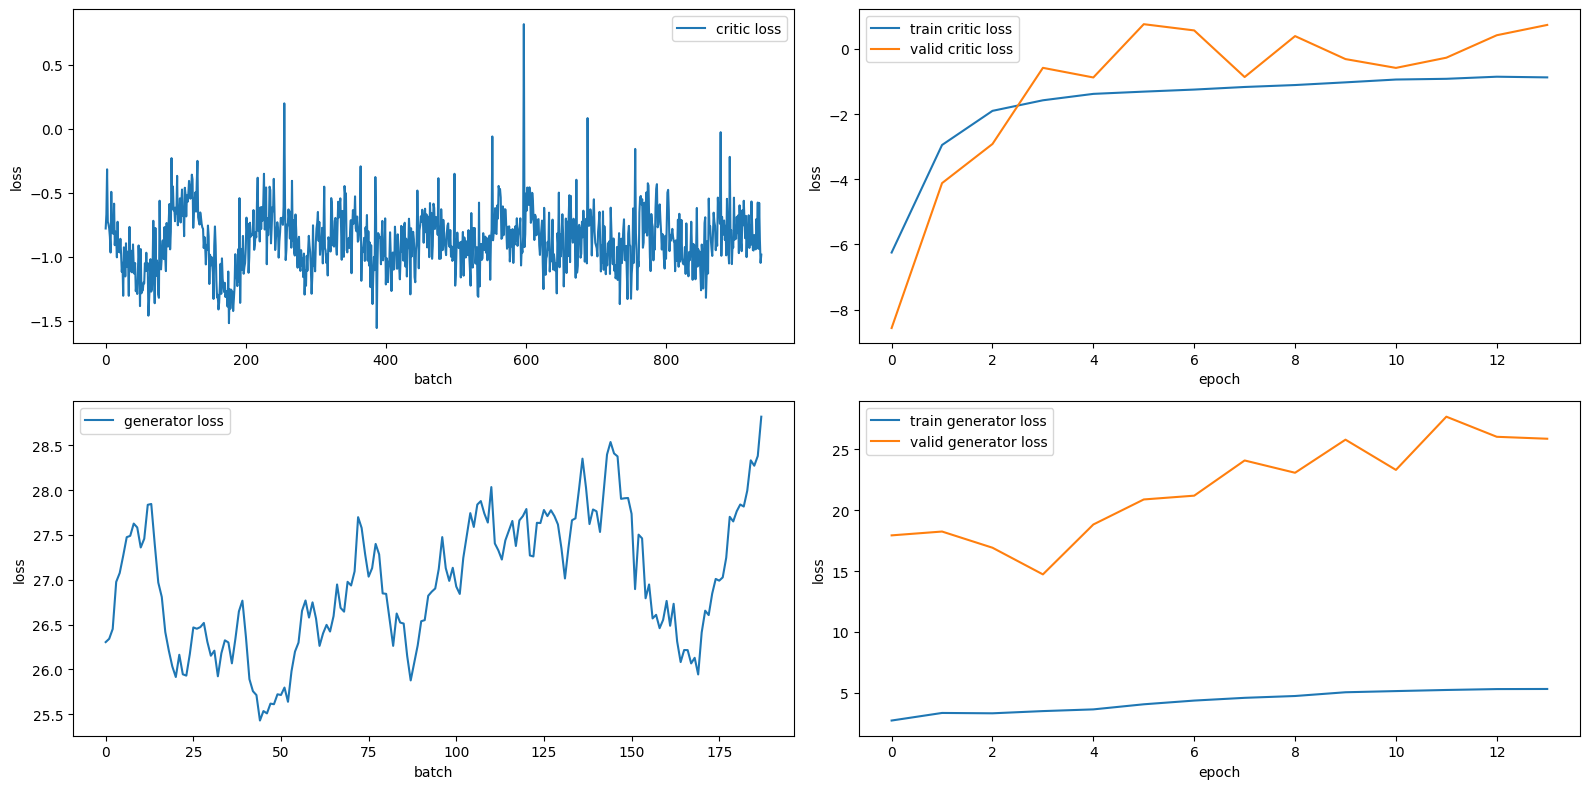

100%|█████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.10it/s]

2024-06-10 18:30:45,571 - root - INFO - Epoch: 14
2024-06-10 18:30:45,572 - root - INFO - c_train_loss: -0.8699151448340909, c_valid_loss: -0.45674917025443834
2024-06-10 18:30:45,573 - root - INFO - g_train_loss: 5.4098703431218, g_valid_loss: 28.59138069397364


In [28]:
train_losses, valid_losses = fit(
    generator=generator,
    critic=critic,
    train_loader=train_loader,
    valid_loader=test_loader,
    generator_optimizer=generator_optimizer,
    critic_optimizer=critic_optimizer,
    start_epoch=start_epoch,
    end_epoch=end_epoch,
)

In [29]:
def show_samples(samples, title, figsize=None, nrow=None):
    if isinstance(samples, np.ndarray):
        samples = torch.FloatTensor(samples)
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow, pad_value=1, padding=1)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(grid_img)
    plt.axis('off')
    plt.show()

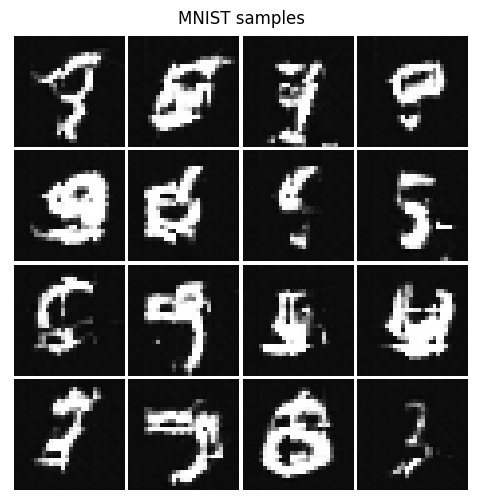

In [30]:
show_samples(generator.sample(16), title='MNIST samples', nrow=4)